# 1번 머신러닝 문제 


* 데이터 설명 : 신용카드 사기 탐지를 위한 예제 데이터이다. 
1. Time : 트랜잭션 시간, 의미 없음  
2. V1~V28 :사용자 ID 및 민감한 기능(v1-v28)을 보호하기 위해 변환된 정보 
3. Amount : 거래금액 
4. Class : 0은 정상, 1은 이상치(신용카드 사기) 

## 1-1 EDA 
## 1-2 상관관계 시각화 전처리 필요함을 설명 

In [ ]:
print('''데이터 전처리 과정
1) EDA
      1. 데이터타입 확인 
      2. 이상치, 결측치 확인
      3. 클래스에 따른 값 범위의 통계적 확인
      3. 변수 간 상관관계 확인
      4. 다중공선성 확인
      5. 클래스 불균형 여부 확인
2) 전처리
      1. scaling 및 one-hot인코딩 처리
      2. 차원축소 시행
      3. 클래스 불균형 처리
''')

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from scipy.stats import zscore
pd.set_option('display.max.columns', 20) 

df= pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/27_problem1.csv")
df.shape

(1193, 20)

In [ ]:
def describeEx(data):
    desc = data.describe().T
    for i, col in enumerate(data.columns):
        outliers = data[np.abs(zscore(data[col])) > 3][col].sort_values()
        desc.loc[col,'type'] = str(data[col].dtype)
        desc.loc[col,'No.of.outliers'] = outliers.size
        desc.loc[col,'outliers min'] = 0 if outliers.size==0 else outliers.values[0]
        desc.loc[col,'outliers max'] = 0 if outliers.size==0 else outliers.values[outliers.size-1]
        desc.loc[col,'No.of.NAs'] = data[col].isna().sum()
    return desc

desc = describeEx(df)
desc
print('''각 설명변수의 값 분포 및 데이터 타입, 결측치, 이상치를 한번에 확인한다.
''' )

In [ ]:
temp = pd.melt(df, id_vars='Class', value_vars=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10','V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17'])
sns.boxplot(hue='Class', x='variable', y='value', data=temp)

print('''
pd.melt 함수는 주어진 dataframe을 3개의 요소 열로 재편해준다.
      기본적으로 여러 개의 변수열(value_vars)에 값이 들어있을 때, [variable:value]의 짝으로 재편하는데, 이 짝에 부여할 id가 있는 경우 id_vars로 할당해준다.
      따라서 기본적으로 value_vars만 사용하거나, id_vars를 함께 사용하게 된다.
      [변수:값] 짝에 각각 이름을 부여하고 싶은 경우 var_name, value_name을 써서 이름을 할당한다.
    id_vars는   
''')

In [ ]:
plt.subplots(1,1, figsize=(12, 12))
sns.heatmap(df.corr(), annot=True)

print('''아래 heatmap에서 보면 
      - 검은 색 계통은 높은 음의 상관관계를 보여주고, 노란색이 옅을 수록 높은 양의 상관관계를 보여준다.
      - V2, V4, V16, V17 등이 다른 기타 설명변수들과 높은 상관관계를 보인다.
      - 실제적으로 문제가 되는 수준일 지 다중공선성 평가가 필요하다.''')


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop(['Class', 'Time'], axis=1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values(by='VIF Factor')

print('''아래 표에서 보듯 5개의 설명변수가 VIF 계수 5를 초과한다.  
      - V14, V3, V10, V16, V12, V17, V7이고 이 중 V7은 거의 10에 해당한다.
      - 10을 초과하지는 않으므로 반드시 제거할 필요는 없으나, 차원축소 시 모델 성능을 평가해볼 필요가 있다.''')
vif

# 1-2 전처리가 필요함 설명 


* 이 데이터 세트는 25,446건의 거래 중 492건의 사기가 있는 거래를 나타냅니다.
* 데이터 세트는 매우 불균형하며 긍정적인 클래스(사기)가 모든 거래의 1.93%를 차지합니다.

1. 변수별로 이상치가 존재하나, 이상치를 찾아 처리하는 과제이므로 이상치를 제거하지는 않는다. 
2. 변수간의 상관성이 높아 전처리가 필요한 것은 없어보인다. 
3. Class 변수의 수를 보면 1이 현저히 작게 분포되어, 클래스의 불균형이 있음을 알 수 있다. 
  - 오버샘플링 or 언더 샘플링으로 처리가 필요해 보인다. 
4. Amount의 경우 다른 변수들과의 수치 값의 차이가 커 모델 사용시, scale을 적용할 필요가 있어 보인다. 


# 2번문제 

## 2-1 차원축소 방법 2가지 이상 비교하고 한가지 선택 
- 주성분분석과 요인분석의 공통점
    - 변수축소 기능 
    - 데이터의 성질과 특징 탐색
    - 다중공선성의 처리되므로 회귀분석 용이
    - 차원축소 후 군집분석 시 속도 향상
    - 차원축소 후 시계열 분석 시 용이
- 주성분분석과의 차이점
    - PCA는 데이터의 분산을 가장 많이 설명하는 축/평면을 찾아내는 것임.
        - 따라서 도출된 순서대로 기여도(설명력)의 차이가 발생함.
        - 따라서 주성분의 개수는 누적 기여도에 따라 임의로 정함
        - 의미 불문, 분산이 설명력이 높은 축/평면을 찾은 것이므로 이름을 붙일 수 없음.
    - FA는 개념적/논리적으로 비슷한 특성들을 묶어 만드는 것임
        - 따라서 도출된 순서는 설명력과 상관이 없고, 우선순위도 없음.
        - 따라서 요인의 개수는 제한이 없고, 분석 과정에서 결정이 됨
        - 개념적/논리적 의도를 전제하므로 하위 변수들을 토대로 이름을 명명함.

## 2-2 추천한 한가지를 실제로 수행하고 선택한 이유 설명 

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

features = df.drop(['Time', 'Class', 'Amount'], axis=1)

# 변수간의 스케일이 차이가 나면 스케일 큰 변수가 주성분에 영향을 많이 주기 때문에 주성분 분석 전에 변수를 표준화한다.
# 해당 데이터의 v1 - v28은 값의 큰 차이가 없으므로 Amount만 -1~1 값으로 표준화 시키도록 하겠다. 
minmax= MinMaxScaler(feature_range=(-3,3))
features['Amount'] = minmax.fit_transform(df[["Amount"]])

pca = PCA(n_components=features.shape[1], svd_solver='auto')
pca_fit = pca.fit(features)

#전체 분산의 80%를 설명하기 위해 필요한 주성분 개수로 결정
e_value = pd.DataFrame({'고유값':pca_fit.explained_variance_, '기여율':pca_fit.explained_variance_ratio_})
e_value['누적기여율'] = e_value['기여율'].cumsum()

print('''주성분 개수를 정하는 방식으로, 전체 기여율이 80%를 초과하는 선에서 결정하는 방식이 있다.
      주성분을 기여율이 큰 것부터 4개를 사용하면 전체 분산의 83%가 설명된다.
      따라서 필요한 주성분 개수를 4개로 설정할 수 있다.
''')
e_value

주성분 개수를 정하는 방식으로, 전체 기여율이 80%를 초과하는 선에서 결정하는 방식이 있다.
      주성분을 기여율이 큰 것부터 4개를 사용하면 전체 분산의 83%가 설명된다.
      따라서 필요한 주성분 개수를 4개로 설정할 수 있다.



,고유값,기여율,누적기여율
0,82.369767,0.662378,0.662378
1,9.812672,0.078909,0.741287
2,6.545275,0.052634,0.793921
3,4.857248,0.039060,0.832980
4,4.600214,0.036993,0.869973
5,2.495256,0.020066,0.890039
6,1.975951,0.015890,0.905928
7,1.696062,0.013639,0.919567
8,1.553235,0.012490,0.932058
9,1.428780,0.011490,0.943547


Text(0.5, 1.0, 'Scree plot')

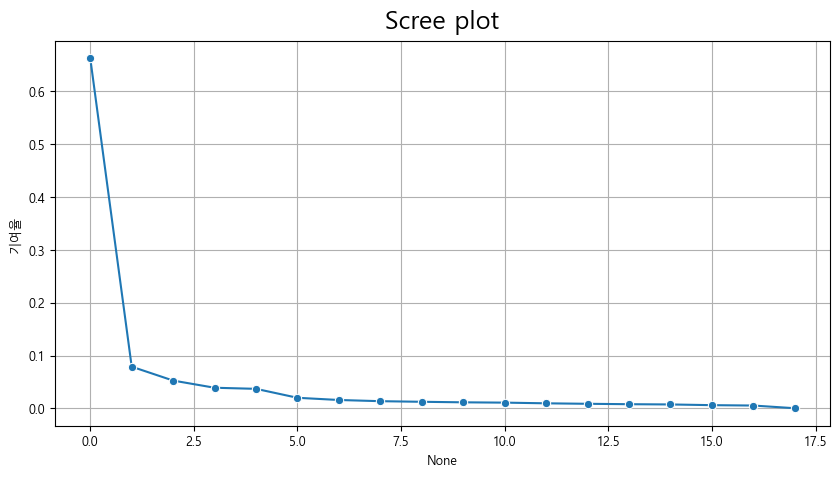

In [63]:
# PCA 고유값 기여율로 Scree plot을 그렸을 때 기울기가 완만해지는 지점으로 주성분 개수 결정
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.lineplot(x=e_value.index, y='기여율', marker='o', data=e_value, ax=ax)
ax.grid()
ax.set_title('Scree plot', fontsize=18, pad=9)


- 우선, 해당 데이터의 의미를 정확하게 이해하고 있지 못할 때에는 분석가의 주관적인 견해가 들어가는 요인분석은 사용하기가 어렵다. (미리 가정을 하고 분석하는 것에 어울림) 
- PCA는 데이터간의 선형 관계만을 가지고 판단하고, 주어진 데이터를 최대한 보존하여 저차원의 데이터를 얻을 수 있으므로 지금과 같은 가명처리 되어있는 변수에 적합한 기법이라 판단하였다. 

## 2-1 문제 풀이 

### 1. 요인분석(FA , Factor Analysis)

- 요인분석은 수집된 많은 변수들이 있을 때, 유사한 항목들(공통차원)들끼리 묵어서 처리하는 기법이다. 이 때에는 독립변수와 종속변수의 개념이 없으며, 모든 변수들간의 관계를 분석함으로써 공통요인을 분석가의 판단으로 묵어서 처리할 수 있다. 

### 2. PCA  주성분분석
* 주성분분석이란 데이터에 여러 변수들이 있을 때, 서로 상관성이 높은 변수들의 선형결합으로 이루어진 "주성분"이라는 새로운 변수를 만들어 변수들을 요약하고 축소하는 기법 
<br>

### <b> 선택 : 해당 데이터에 어울리는 분석은 PCA이다. </b>



## 2-2 문제풀이 

* 변수간의 스케일이 차이가 나면 스케일 큰 변수가 주성분에 영향을 많이 주기 때문에 주성분 분석 전에 변수를 표준화나 
  정규화시켜주는 것이 좋지만, 해당 데이터의 v1 - v28은 값의 큰 차이가 없으므로 Amount만 -1~1 값으로 표준화 시키도록 하겠다. 
  
* 파이썬에서 주성분분석을 수행할 수 있는 기본적인 함수는 sklearn의 PCA함수이다. 
* pca.explained_variance_ratio_를 통해서 또는 Scree Plot으로 주성분의 설명력을 확인 할 수 있다. 
* PCA함수는 공분산행렬의 고유벡터를 구하는 방법을 사용한다. 





1. 추천한 이유 

- 우선, 해당 데이터의 의미를 정확하게 이해하고 있지 못할 때에는 분석가의 주관적인 견해가 들어가는 요인분석은 사용하기가 어렵다. (미리 가정을 하고 분석하는 것에 어울림) 
- PCA는 데이터간의 선형 관계만을 가지고 판단하고, 주어진 데이터를 최대한 보존하여 저차원의 데이터를 얻을 수 있으므로 지금과 같은 가명처리 되어있는 변수에 적합한 기법이라 판단하였다. 
<br>



In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
scaled_Amount = scaler.fit(df[["Amount"]])
scaled_Amount.transform(df[["Amount"]])

array([[-0.94639854],
       [-1.        ],
       [-0.99029298],
       ...,
       [-0.97168836],
       [-0.91006466],
       [-0.99646254]])

In [65]:
df["Scaled_Amount"] = scaler.transform(df[["Amount"]])

In [66]:
#차원을 축소할 데이터만 추출
features = df.columns.drop(["Time","Class","Amount"])
features

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'Scaled_Amount'],
      dtype='object')

In [67]:
from sklearn.decomposition import PCA
## Scree Plot 으로 주성분 개수 정하는 방법 
pca = PCA(n_components=29)
pca_fit = pca.fit(df[features])

ValueError: n_components=29 must be between 0 and min(n_samples, n_features)=18 with svd_solver='covariance_eigh'

In [11]:
print("\n ==================== PCA Result Summary ===================")
print("\n고유 값 : \n",pca.singular_values_)
print("\n분산 설명력: \n", pca.explained_variance_ratio_)


 ==================== PCA Result Summary ===================

고유 값 : 
 [567.40353285 313.45944868 268.76925763 247.49557957 245.21558213
 234.06558568 220.88939828 215.16741395 206.74283044 176.47206584
 173.82711864 167.10086384 161.65414737 159.55696026 156.95791012
 145.83772876 141.74985119 139.47656662 133.43897447 131.24172456
 127.45072644 116.14690455 103.96599455  96.52319279  84.19066543
  76.7381171   66.79198064  46.95762978   1.67231048]

분산 설명력: 
 [2.83079430e-01 8.63946745e-02 6.35160417e-02 5.38591053e-02
 5.28713463e-02 4.81725206e-02 4.29016491e-02 4.07077635e-02
 3.75824560e-02 2.73826945e-02 2.65680270e-02 2.45517036e-02
 2.29772444e-02 2.23849305e-02 2.16616062e-02 1.87009654e-02
 1.76672708e-02 1.71051441e-02 1.56563180e-02 1.51449589e-02
 1.42826526e-02 1.18614975e-02 9.50400961e-03 8.19195579e-03
 6.23235418e-03 5.17781488e-03 3.92258972e-03 1.93881592e-03
 2.45899739e-06]


분산설명력은 PCA를 사용했을 때, 주성분 1~29까지가 원본 데이터를 얼마나 설명할 수 있는가를 알려준다. 이를 시각화하여 원본데이터를 설명할 수 있는 최적의 주성분 개수를 파악할 수 있다. 

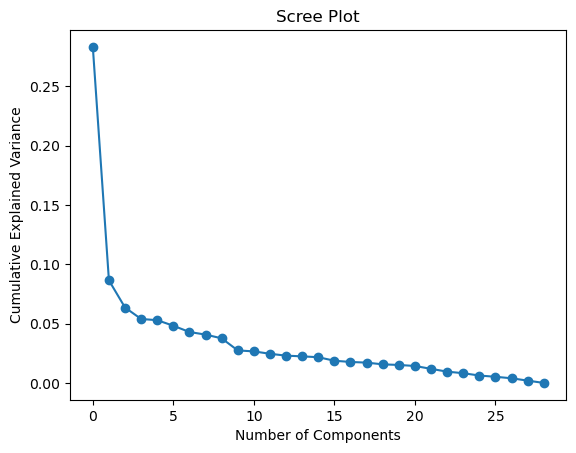

In [12]:
# Scree Plot 
import matplotlib.pyplot as plt
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca.explained_variance_ratio_,'o-')

In [13]:
print("주성분 3개로 축소할 시 분산설명력 : ",pca.explained_variance_ratio_[:3].sum()*100) 
print("주성분 9개로 축소할 시 분산설명력 : ",pca.explained_variance_ratio_[:9].sum()*100)

주성분 3개로 축소할 시 분산설명력 :  43.29901465777061
주성분 9개로 축소할 시 분산설명력 :  70.90849873887333


## 2. PCA 결과 

- 해당 데이터는 앞서 주성분 그림만 보아서는 3개의 차원축소 값으로 사용하면 되어 보이지만 분산 설명력이 전체 데이터의 50%도 되지 않으므로 하나의 성분하나하나가 개별적 의미를 가진다고 볼 수 있다. 

- 그러므로 해당 데이터에서 차원의 축소는 적합하지 않아보인다.


## 3.오버샘플링/언더샘플링

3.1 오버샘플링과 언더샘플링 장단점 비교 및 선택 구현

3.2 분류 분석에 대한 구현 및 알고리즘 2가지 (오버샘플링, 언더샘플링) 비교, 성능 측정

3.3 현재까지 전처리한 데이터를 통해 분류 모델 수행 후 결과 분석

## 답안

### 오버샘플링  
데이터 세트의 균형을 맞추기 위해 업 샘플링을 적용할 수 있다.
대표적으로 랜덤 오버샘플링과 KNN을 이용한 SMOTE기법이 있다.
1.  랜덤오버샘플링은 소수 클래스의 정보를 복제하여 다수 클래스의 크기에 맞추는 기법이며, 이는 오버피팅의 우려가 있다.
2.  SMOTE는 KNN을 이용하여 최근접 이웃의 거리 계산을 통해 K개의 중간 지점의 데이터를 생성한다. 오버피팅을 막을 수 있으나, 새로운 데이터나 작은 데이터셋에서는 사용하기가 어렵다.

### 언더샘플링
언더 샘플링은 다수 데이터를 소수 데이터의 크기에 맞추는 기법이다.
랜덤 샘플링을 통해 소수의 클래스로 만드는 과정에서 데이터의 손실이 발생하는 문제가 있을 수 있다. 소수 클래스의 크기가 너무 작을 경우 머신러닝 과정에서의 과소적합이 발생할 수 있다.



#### 데이터 셋이 크기 때문에 언더샘플링을 하게되면 데이터의 손실이 너무 크므로 오버샘플링 선택


C:\Users\jjang\anaconda3\envs\ADP_Class\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


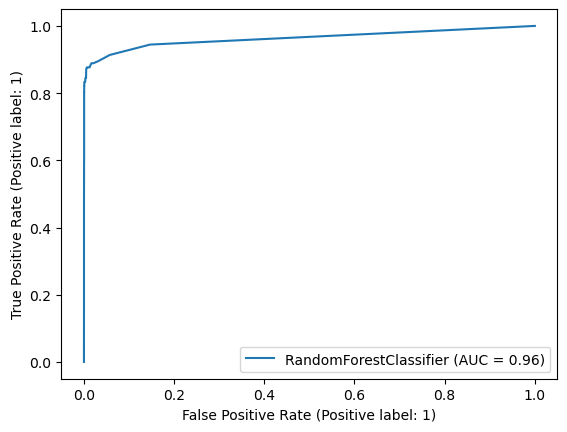

In [14]:
## 원본 학습 시, 모델 : 컬럼이 많은 데이터셋에서도 적용가능한 랜덤포레스트 앙상블 모델 사용 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split

X = df[features]
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=321)
clf = RandomForestClassifier(random_state=321) 
clf.fit(X_train,y_train)

plot_roc_curve(clf, X_test, y_test)

C:\Users\jjang\anaconda3\envs\ADP_Class\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


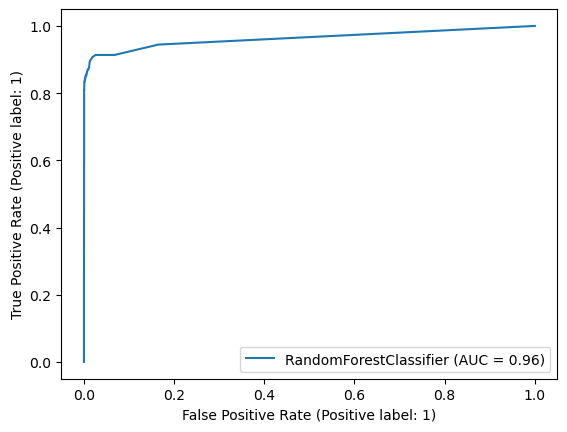

In [15]:
## 1번 오버샘플링 기법 - 랜덤오버샘플링 
import imblearn. over_sampling
from imblearn.over_sampling import  RandomOverSampler
X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)

clf_re = RandomForestClassifier(random_state=0) 
clf_re.fit(X_resampled,y_resampled)

plot_roc_curve(clf_re, X_test, y_test)

C:\Users\jjang\anaconda3\envs\ADP_Class\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


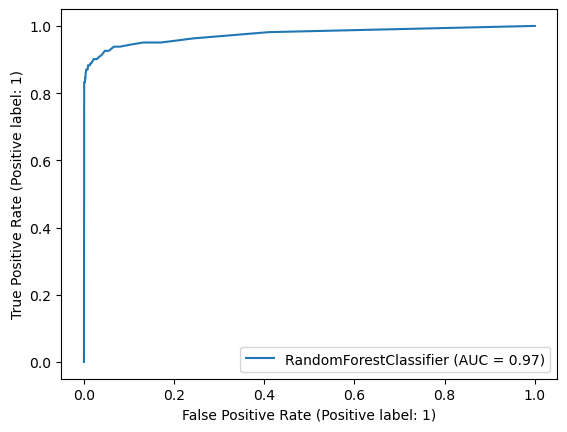

In [16]:
## 2번 오버샘플링 - SMOTE 

from imblearn.over_sampling import SMOTE
# 모델설정
sm = SMOTE( k_neighbors=5,random_state=2020)

# train데이터를 넣어 복제함
X_resampled_over, y_resampled_over = sm.fit_resample(X_train,y_train)

clf_over = RandomForestClassifier(random_state=2020) 
clf_over.fit(X_resampled_over,y_resampled_over)

plot_roc_curve(clf_over, X_test, y_test)

## 3.3 현재까지 전처리한 데이터를 통해 모델 수행 후 결과 분석  

* 오버샘플링을 2개의 기법 중, SMOTE기법의 AUC가 더 높은 것으로 보아, SMOTE 기법이 불균형한 소수 클래스의 특징을 잘 반영하여 데이터를 생성하였다고 볼 수 있다. 

* 하지만, 랜덤포래스트와 같은 경우 오버샘플링 기법이 없이도 0.96이라는 높은 예측력을 보이므로, 굳이 가상의 데이터를 만들어 예측력을 높이는 오버샘플링을 적용시킬 필요가 없는 데이터라고 할 수도 있다. 

# 4번 

4.1 이상탐지 모델 2가지 이상 기술, 장/단점 설명

4.2 앞에서 만든 데이터로 한 가지 이상탐지 모델을 구현하고, 3번에서 만든 모델과 비교

4.3 데이터분석가 관점에서 3번에서 만든 모델과 4번에서 만든 모델 설명

## 4.1 이상탐지 모델 2가지 이상 기술 장/단점 설명 

1. DBSCAN 
- 클러스터가 더 낮은 밀도의 영역으로 분리된 공간의 밀도가 높은 영역이라는 가정하에 작동한다.
- 데이터를 클러스터링하기 위해 DBSCAN 알고리즘은 데이터의 고밀도 영역과 저밀도 영역을 분리합니다. 거리와 군집당 최소 데이터 수를 사용하여 이상 데이터를 특이치로 분류합니다


장/단점 
- DBSCAM의 경우 주변 데이터에서 멀어지는 데이터의 특징을 찾아서 Class를 분류하기에 0 or 1이 아닌 특이점이라도 발견 할 수 있다. 아웃라이어를 탐색하는데에 적합하다. 하지만, 데이터의 특성을 잘 파악하여 군집 밀도와 최소 데이터 수 등 파라미터를 조정하는 것이 어려운 단점이 있다. 


2. SVM 
- 데이터를 선형모델을 분류하고자 할 때, 선형으로 완전히 분류할 수 없는 데이터의 차원을 올려주어 선으로 분류할 수 있게 커널트릭을 사용하여 데이터를 분류하는 방법이다. 
- SVM 분류 모델은 데이터 공간에 존재하는 경계로 표현되며, 데이터를 분류하는 여러 경계 중에서 가장 큰 마진으로 갖는 경계를 찾는다. 이 경계를 이용하여 이상치 Class1을 찾을 때에 이 모델을 사용할 수 있다. 

장/단점 
- SVM의 경우는 비선형 분류에도 사용되어 오류 데이터에 대한 영향이 거의 없으므로, 과적합되는 경우가 적다. 즉, 오류가 많을 경우에는 해당 모델이 강점을 보일 수 있다. 
- 하지만, SVM은 학습속도가 느리고,  해석이 어렵고 복잡한 모델이라는 단점이있다. 

## 4.2 앞에서 만든 데이터로 한 가지 이상탐지 모델을 구현하고, 3번에서 만든 모델과 비교

- DBSCAN 이상탐지를 이용하기 위해서 적절한 epsilon 과 minPoints 값을 찾아야 한다. 
- epsilon 의 경우 K-distance 그래프를 사용하여 판단할 수 있다. 
- K 거리 그래프를 그리려면 데이터 세트의 모든 데이터 포인트에 대해 포인트와 가장 가까운 데이터 포인트 사이의 거리가 필요한데, sklearn.neighbors 에서 NearestNeighbors를 사용하여, 거리를 알 수 있다.

In [17]:
## 예제 데이터가 너무 크므로, 학습 속도를 위해 랜덤샘플링 // 아마 실제 시험에서는 이정도로 큰 데이터는 제시하지 않을 것입니다. 샘플사이즈를 1/5 줄여서 학습시키겠습니다. 
features.drop("Scaled_Amount")
df_sample = df.sample(n=5000)
df_sample = df_sample.drop(df_sample[df_sample["Class"]==1].index)
df_outlier = df[df["Class"]==1].sample(n=60)
df_sample_com = pd.concat([df_sample,df_outlier])
X_sp = df_sample_com[features]
y_sp = df_sample_com["Class"]

In [18]:
from sklearn.neighbors import NearestNeighbors
import numpy as np 
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_sp)
distances, indices = nbrs.kneighbors(X_sp)
 
#거리 변수는 데이터 세트의 모든 데이터 포인트에 대해 데이터 포인트와 가장 가까운 데이터 포인트 사이의 거리 배열을 포함

distances

array([[5.96046448e-08, 1.71158266e+00],
       [0.00000000e+00, 6.08443073e-01],
       [0.00000000e+00, 2.53024732e+00],
       ...,
       [0.00000000e+00, 1.10404818e+01],
       [0.00000000e+00, 3.47969765e+00],
       [0.00000000e+00, 7.22497784e+00]])

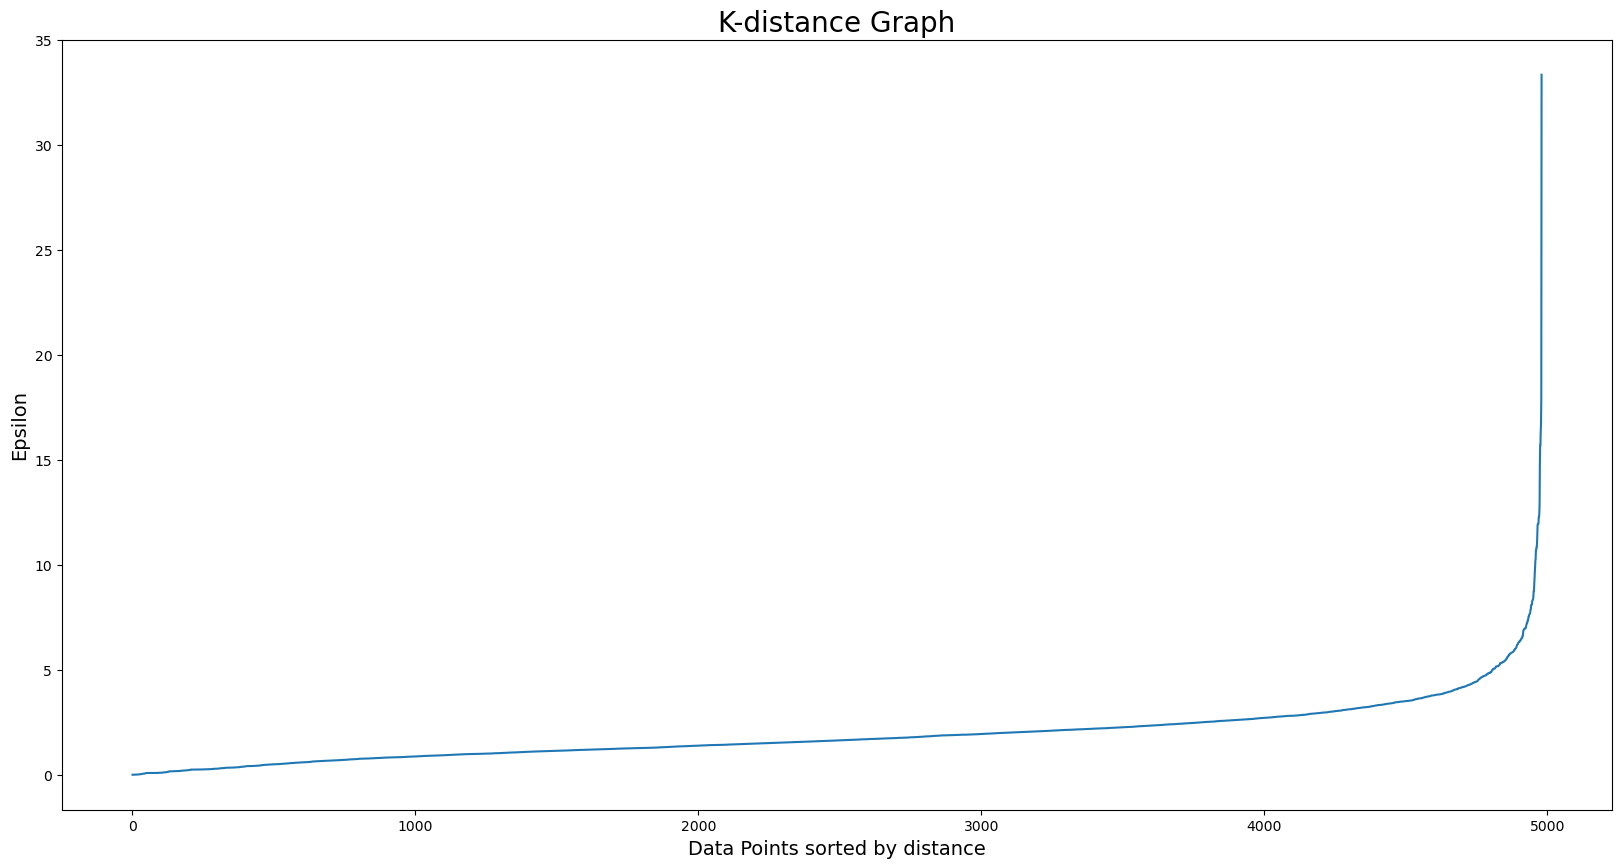

In [19]:

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

#엡실론 의 최적 값은 K-거리 그래프에서 최대 곡률 지점에 있으며 이 경우 5정도로 지정해주겠습니다. 이제 minPoints 의 값을 찾을 차례입니다 . minPoints 의 값 도 도메인 지식에 따라 다릅니다. 이번에는 minPoints를 10으로 사용합니다.

모#델이 취하는 두 가지 가장 중요한 매개변수 값은 (i) 두 포인트 사이의 거리를 지정하는 esp 입니다. 즉, 클러스터의 일부로 간주되기 위해 데이터 포인트가 서로 얼마나 가까워야 하는지를 지정합니다. (ii) min_samples는 포인트가 클러스터에 있어야 하는 최소 이웃 수를 지정합니다.

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# scale data first

db = DBSCAN(eps=6, min_samples=10).fit(X_sp)
labels = db.labels_

data = pd.DataFrame()
data["Class"] = y_sp.copy()
data["labels"] = labels
data.loc[data["labels"]==-1,'Class'].sum()

53

## 60개의 이상치 중 53개를 분류해내었다. 
 - DBSCAN의 놀라운 점은 데이터 세트에서 노이즈를 꽤 잘 분리한다. 
 - 여기서 0은 양호한 클러스터이고 -1은 노이즈입니다.

In [25]:
data[data["Class"]==1].sum()

Class     60
labels   -53
dtype: int64

In [26]:
data.loc[data["labels"]==-1]

,Class,labels
13781,0,-1
21351,0,-1
3546,0,-1
9744,0,-1
8105,0,-1
...,...,...
25342,1,-1
25080,1,-1
24978,1,-1
25397,1,-1


In [66]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

## CM을 그리기 위해서 -1을 Class와 같이 1로 변경) 
data.loc[data.labels==-1, "labels"] = 1
confusion_matrix(data.Class,data.labels)

array([[4822,   99],
       [   7,   53]], dtype=int64)

In [67]:
accuracy = metrics.accuracy_score(data.Class,data.labels)
print("정확도:", accuracy)

precision = metrics.precision_score(data.Class,data.labels)
print("정밀도:", precision)

recall = metrics.recall_score(data.Class,data.labels)
print("재현율:", recall)

f1 = metrics.f1_score(data.Class,data.labels)
print("f1 점수:", f1)

정확도: 0.9787191327042762
정밀도: 0.34868421052631576
재현율: 0.8833333333333333
f1 점수: 0.5


## 4.3 데이터분석가 관점에서 3번에서 만든 모델과 4번에서 만든 모델 설명

# 결론
 - labels 가 -1이면서 Class가 0인 고객은 위험군으로 분류할 수 있다. 
 - 4번 모델에서 labels 가 -1이면서 Class가 0인 고객은 위험군으로 분류할 수 있다. 분류의 정확도만 보자면 3번의 RandomForest 모델의 정확도가 훨씬 높아 사기를 당할 확률을 예상할 때에는 RandomForest모델이 좋아보인다. 하지만, 0과 1의 분류가 아닌 정상의 범주를 벗어나는 여러 케이스가 있을 경우에는 분류해내기 어렵다. 하지만 DBSCAN과 같은 거리기반 이상치 탐지는 정상으로 분류되지 않은 이상치를 가지고 위험군으로 관리할 수 있는 장점이 있다.
